In [ ]:
# vtreat

# Setting up vtreat for a binomial classification problem
treatment = vtreat.BinomialOutcomeTreatment(
    outcome_name='readmitted',
    outcome_target=1,  # Target for binary classification
    cols_to_copy=None,  # Copy without any transformation
    params={
        'filter_to_recommended': True,
        'indicator_min_fraction': 0.01
    }
)

# Fitting the treatment to the training data
Xy_train = pd.concat([X_train, y_train], axis=1)
train_treated = treatment.fit_transform(Xy_train)

# Transform the test data using the same treatment
Xy_test = pd.concat([X_test, y_test], axis=1)
test_treated = treatment.transform(Xy_test)

# examine score frame
# treatment.score_frame_

# recommended variables
# treatment.score_frame_.loc[treatment.score_frame_['recommended'], ['variable']]

# not recommended variables
# treatment.score_frame_.loc[~treatment.score_frame_['recommended'], ['variable']]

In [ ]:
#data = (train_treated.drop(columns=['readmitted']), 
#        test_treated.drop(columns=['readmitted']), 
#        train_treated['readmitted'], 
#        test_treated['readmitted'])

In [ ]:
#gb.fit(train_treated.drop(columns=['readmitted']), train_treated['readmitted']) # 0.721

In [ ]:
####################################
########## SIMULATED DATA ##########
####################################

from sklearn import datasets

random_state = 109

# create dataset for binary classification with 5 predictors
X, y = datasets.make_classification(
    n_samples=1000,
    n_features=5,
    n_informative=3,
    n_redundant=2,
    random_state=random_state
)

# split into training and test
X_train_transformed, X_test_transformed, y_train, y_test = train_test_split(
    X, y,
    train_size=0.8,
    random_state=random_state
)

X_train_transformed = pd.DataFrame(X_train_transformed, columns=['one', 'two', 'three', 'four', 'five'])
X_test_transformed = pd.DataFrame(X_test_transformed, columns=['one', 'two', 'three', 'four', 'five'])

In [ ]:
# Lasso Logistic Regression

# C values to try 
Cs = [1e-1, 1e0, 1e1, 1e2, 1e3]

# logistic regression model with elasticnet penalty and 10-fold CV
lrr = LogisticRegressionCV(
    Cs=Cs, cv=10, penalty='elasticnet', solver='saga', n_jobs=-1, # solver='liblinear' for l1
    scoring='roc_auc', max_iter=1000, random_state=109, l1_ratios=[0, 0.5, 1],
)

start_time = time.time()

lrr.fit(X_train_transformed, y_train)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

In [ ]:
best_C = lrr.C_
print("Best C for each class: ", best_C)

In [ ]:
# get scores
scores = lrr.scores_

# Calculate mean scores across all folds
mean_scores = {class_label: score.mean(axis=0) for class_label, score in scores.items()}

# Print mean scores
print("Mean Validation Scores: ", mean_scores)

In [ ]:
# SVM

from sklearn.svm import SVC

# hyperparameter tuning dictionary
params = {
    'random_state': [109],
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['rbf'],
    'gamma': ['scale'],
    'shrinking': [True],
    'probability': [True], 
    'class_weight': ['balanced']
}

# 10-fold CV
svc = GridSearchCV(
    estimator=SVC(),
    param_grid=params,
    cv=3,
    scoring='roc_auc',
    refit=True,
    return_train_score=True,
    n_jobs=-1
)

start_time = time.time()

# fit the model
svc.fit(X_train_transformed, y_train)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

print("\nBest parameters:", svc.best_params_, "\n\nAUCROC:", round(svc.best_score_, 3))

In [ ]:
from gower import gower_matrix

# Compute the Gower distance matrix for the training data
distance_matrix_train = gower_matrix(X_train_transformed)

# Compute the Gower distance from each test point to every training point
distance_matrix_test = gower_matrix(X_test_transformed, X_train_transformed)

In [ ]:
# K-NN

# hyperparameter tuning dictionary
params = {
    'n_neighbors': [5],
    'weights': ['distance'],
    'metric': ['precomputed'] 
}

# 10-fold CV
knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=params,
    cv=5,
    scoring='roc_auc',
    refit=True,
    return_train_score=True,
    n_jobs=-1
)

start_time = time.time()

# fit the model
knn.fit(distance_matrix_train, y_train)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

print("\nBest parameters:", knn.best_params_, "\n\nAUCROC:", round(knn.best_score_, 3))

In [ ]:
from utility_functions import get_previous_encounters, aggregate_previous_encounters, get_last_encounter, aggregate_encounters

### GMM

In [120]:
from sklearn.mixture import GaussianMixture

# range of cluster numbers to try
cluster_numbers = [2, 10, 20, 30, 40, 50, 60]

# lists to store BIC and AIC values
bics = []
aics = []

start_time = time.time()

# iterate over cluster numbers
for n_clusters in cluster_numbers:
    gmm = GaussianMixture(n_components=n_clusters, random_state=109)
    gmm.fit(X_train_transformed)
    bics.append(gmm.bic(X_train_transformed))
    aics.append(gmm.aic(X_train_transformed))

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

Model fitting time: 579.7 seconds


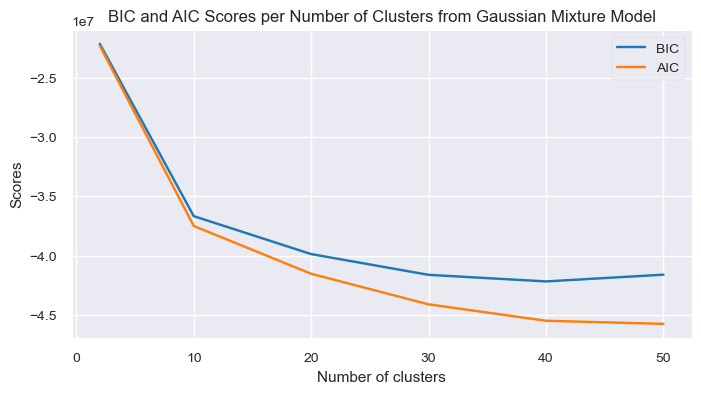

Best number of clusters according to BIC: 40
Best number of clusters according to AIC: 50


In [128]:
# plot BIC and AIC
plt.figure(figsize=(8, 4))
plt.plot(cluster_numbers, bics, label='BIC')
plt.plot(cluster_numbers, aics, label='AIC')
plt.xlabel('Number of clusters')
plt.ylabel('Scores')
plt.legend()
plt.title('BIC and AIC Scores per Number of Clusters from Gaussian Mixture Model')
plt.show()

# find the number of clusters that minimizes BIC and AIC
best_cluster_bic = cluster_numbers[np.argmin(bics)]
best_cluster_aic = cluster_numbers[np.argmin(aics)]

print(f"Best number of clusters according to BIC: {best_cluster_bic}")
print(f"Best number of clusters according to AIC: {best_cluster_aic}")

In [127]:
# best number of clusters
best_n_clusters = min(best_cluster_bic, best_cluster_aic)

start_time = time.time()

# fit GMM to the training set
gmm = GaussianMixture(n_components=best_n_clusters, random_state=109)
gmm.fit(X_train_transformed)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

Model fitting time: 250.9 seconds


In [656]:
# assign cluster labels
cluster_train_labels_df = pd.DataFrame(gmm.predict(X_train_transformed), columns=['cluster'])
cluster_test_labels_df = pd.DataFrame(gmm.predict(X_test_transformed), columns=['cluster'])

# create dummy variables
cluster_train_dummies_df = pd.get_dummies(cluster_train_labels_df, columns=['cluster'], prefix='cluster', dtype=int)
cluster_test_dummies_df = pd.get_dummies(cluster_test_labels_df, columns=['cluster'], prefix='cluster', dtype=int)

In [657]:
# set the index of the dummies to be the same as main data
cluster_train_dummies_df.index = X_train_transformed.index
cluster_test_dummies_df.index = X_test_transformed.index

In [658]:
# concatenate dummy variables with main DataFrame
X_train_transformed = pd.concat([X_train_transformed, cluster_train_dummies_df], axis=1)
X_test_transformed = pd.concat([X_test_transformed, cluster_test_dummies_df], axis=1)

In [659]:
# add any missing dummy columns in test set
missing_cols = set(X_train_transformed.columns) - set(X_test_transformed.columns)
for col in missing_cols:
    X_test_transformed[col] = 0

# reorder columns in test set to match training set
X_test_transformed = X_test_transformed[X_train_transformed.columns]

In [660]:
# check training and testing set dimensions
print('Training set dimensions: ', X_train_transformed.shape)
print('Testing set dimensions: ', X_test_transformed.shape)

Training set dimensions:  (55992, 175)
Testing set dimensions:  (13998, 175)


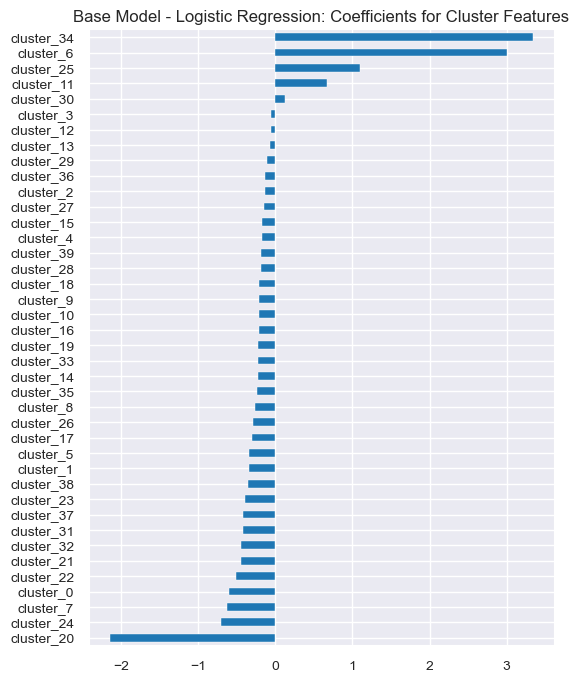

In [672]:
cluster_features = [feature for feature in base_model.feature_names_in_ if feature.startswith('cluster_')]
cluster_coefs    = [coef for feature,coef in zip(base_model.feature_names_in_,base_model.coef_.ravel())
                                             if feature.startswith('cluster_')]

plt.figure(figsize=(6,8))
coef = pd.Series(cluster_coefs, index=cluster_features)
_ = coef.sort_values().plot.barh().set_title('Base Model - Logistic Regression: Coefficients for Cluster Features')

In [ ]:
# Single Decision Tree

# hyperparameter tuning dictionary
params = {'random_state': [109], 
          'criterion': ['gini'], 
          'splitter': ['best'], 
          'max_depth': range(3, 5),
          'min_samples_split': range(2, 30),
          'min_samples_leaf': [1], 
          'min_weight_fraction_leaf': [0.0], 
          'max_features': [None], 
          'max_leaf_nodes': [None], 
          'min_impurity_decrease': [0.0], 
          'class_weight': ['balanced'],
          'ccp_alpha': [0.0]
         }

# 10-fold CV
dt = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=params,
    cv=5,
    scoring='roc_auc',
    return_train_score=True
)

start_time = time.time()

dt.fit(X_train_transformed, y_train)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

### Naive Bayes

In [ ]:
# Define the parameter grid
params = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

# Initialize GridSearchCV
nb = GridSearchCV(
    estimator=GaussianNB(), 
    param_grid=params, 
    cv=5, 
    scoring='roc_auc',
    refit=True,
    return_train_score=True,
    n_jobs=-1
)

start_time = time.time()

# fit the model
nb.fit(X_train_transformed, y_train)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

print("\nBest parameters:", nb.best_params_, "\n\nAUC-ROC:", round(nb.best_score_, 3))

### Random Forest

In [ ]:
# Random Forest

# hyperparameter tuning dictionary
params = {
    'random_state': [109],
    'n_estimators': [100, 200],
    'criterion': ['gini'],
    'max_depth': [None],
    'min_samples_split': [2,5,10,20],
    'min_samples_leaf': [1],
    'min_weight_fraction_leaf': [0.0],
    'max_features': ['sqrt'],
    'max_leaf_nodes': [None], 
    'min_impurity_decrease': [0.0],
    'bootstrap': [True], 
    'oob_score': [False],
    'n_jobs': [-1],
    'warm_start': [False], 
    'class_weight': ['balanced'],
    'ccp_alpha': [0.0]
}

# 10-fold CV
rf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=params,
    cv=5,
    scoring='roc_auc',
    refit=True,
    return_train_score=True,
    n_jobs=-1
)

start_time = time.time()

# fit the model
rf.fit(X_train_transformed, y_train)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

print("\nBest parameters:", rf.best_params_, "\n\nAUC-ROC:", round(rf.best_score_, 3))